### Импорты 

In [66]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка данных

In [60]:
with open('catboost_grid_search_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [68]:
with open('../data/x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)

with open('../data/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)

with open('../data/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [62]:
cat_features = ['home_ownership',
 'years_in_current_job',
 'tax_liens',
 'number_of_credit_problem',
 'bankruptcies',
 'purpose',
 'term',
 'num_features_clustered_by_3',
 'num_features_clustered_by_4']

num_features = ['income',
 'number_of_open_accounts',
 'years_of_credit_history',
 'maximum_open_credit',
 'current_loan_amount',
 'current_credit_balance',
 'monthly_debt',
 'credit_score',
 'mean_credit_score_per_history',
 'current_credit_balance_per_income',
 'months_to_pay_per_month_of_credit_history',
 'income_per_credit_history',
 'number_of_credit_problem_per_history',
 'number_of_bankruptcies_per_history',
 'monthly_income_per_monthly_debt',
 'current_loan_amount_per_income',
 'PCA_5_0',
 'PCA_5_1',
 'PCA_5_2',
 'PCA_5_3',
 'PCA_5_4']

target = 'credit_default'

### Выбор фичей

In [6]:
model.feature_importances_

array([ 4.21330262,  3.16130119,  0.        ,  0.10328621,  1.34266555,
        1.31428997,  3.62795248,  0.        ,  0.46352589,  0.        ,
        8.09863045, 11.65824876,  2.1323761 ,  2.18317363,  5.65103665,
       15.92098135, 14.86925615,  2.43191666,  1.67555965,  0.71403275,
        0.62605707,  2.44504068,  4.91591954,  1.9354551 ,  3.36705002,
        1.17605695,  1.36095703,  1.36869591,  1.79052552,  1.45270609])

In [7]:
mut_info = mutual_info_classif(x_train[num_features], y_train, n_neighbors=3)

In [8]:
mut_info

array([0.00555546, 0.00863277, 0.        , 0.0075956 , 0.03752498,
       0.00998733, 0.        , 0.02684779, 0.        , 0.01605586,
       0.02870793, 0.00282515, 0.        , 0.        , 0.01096624,
       0.04672043, 0.00465793, 0.01436717, 0.00342866, 0.01400936,
       0.00201842])

In [9]:
x_train[num_features].columns

Index(['income', 'number_of_open_accounts', 'years_of_credit_history',
       'maximum_open_credit', 'current_loan_amount', 'current_credit_balance',
       'monthly_debt', 'credit_score', 'mean_credit_score_per_history',
       'current_credit_balance_per_income',
       'months_to_pay_per_month_of_credit_history',
       'income_per_credit_history', 'number_of_credit_problem_per_history',
       'number_of_bankruptcies_per_history', 'monthly_income_per_monthly_debt',
       'current_loan_amount_per_income', 'PCA_5_0', 'PCA_5_1', 'PCA_5_2',
       'PCA_5_3', 'PCA_5_4'],
      dtype='object')

In [10]:
pd.Series(mut_info, index=x_train[num_features].columns).sort_values(ascending=0)

current_loan_amount_per_income               0.046720
current_loan_amount                          0.037525
months_to_pay_per_month_of_credit_history    0.028708
credit_score                                 0.026848
current_credit_balance_per_income            0.016056
PCA_5_1                                      0.014367
PCA_5_3                                      0.014009
monthly_income_per_monthly_debt              0.010966
current_credit_balance                       0.009987
number_of_open_accounts                      0.008633
maximum_open_credit                          0.007596
income                                       0.005555
PCA_5_0                                      0.004658
PCA_5_2                                      0.003429
income_per_credit_history                    0.002825
PCA_5_4                                      0.002018
number_of_credit_problem_per_history         0.000000
number_of_bankruptcies_per_history           0.000000
mean_credit_score_per_histor

In [31]:
pd.Series(model.feature_importances_, index=x_train.columns).sort_values()[:25]

years_in_current_job                         0.000000
number_of_credit_problem                     0.000000
purpose                                      0.000000
tax_liens                                    0.103286
bankruptcies                                 0.463526
number_of_bankruptcies_per_history           0.626057
number_of_credit_problem_per_history         0.714033
PCA_5_0                                      1.176057
years_of_credit_history                      1.314290
number_of_open_accounts                      1.342666
PCA_5_1                                      1.360957
PCA_5_2                                      1.368696
PCA_5_4                                      1.452706
mean_credit_score_per_history                1.675560
PCA_5_3                                      1.790526
current_loan_amount_per_income               1.935455
current_credit_balance                       2.132376
monthly_debt                                 2.183174
income_per_credit_history   

In [12]:
train = x_train.copy()
train['target'] = y_train.values

<AxesSubplot:>

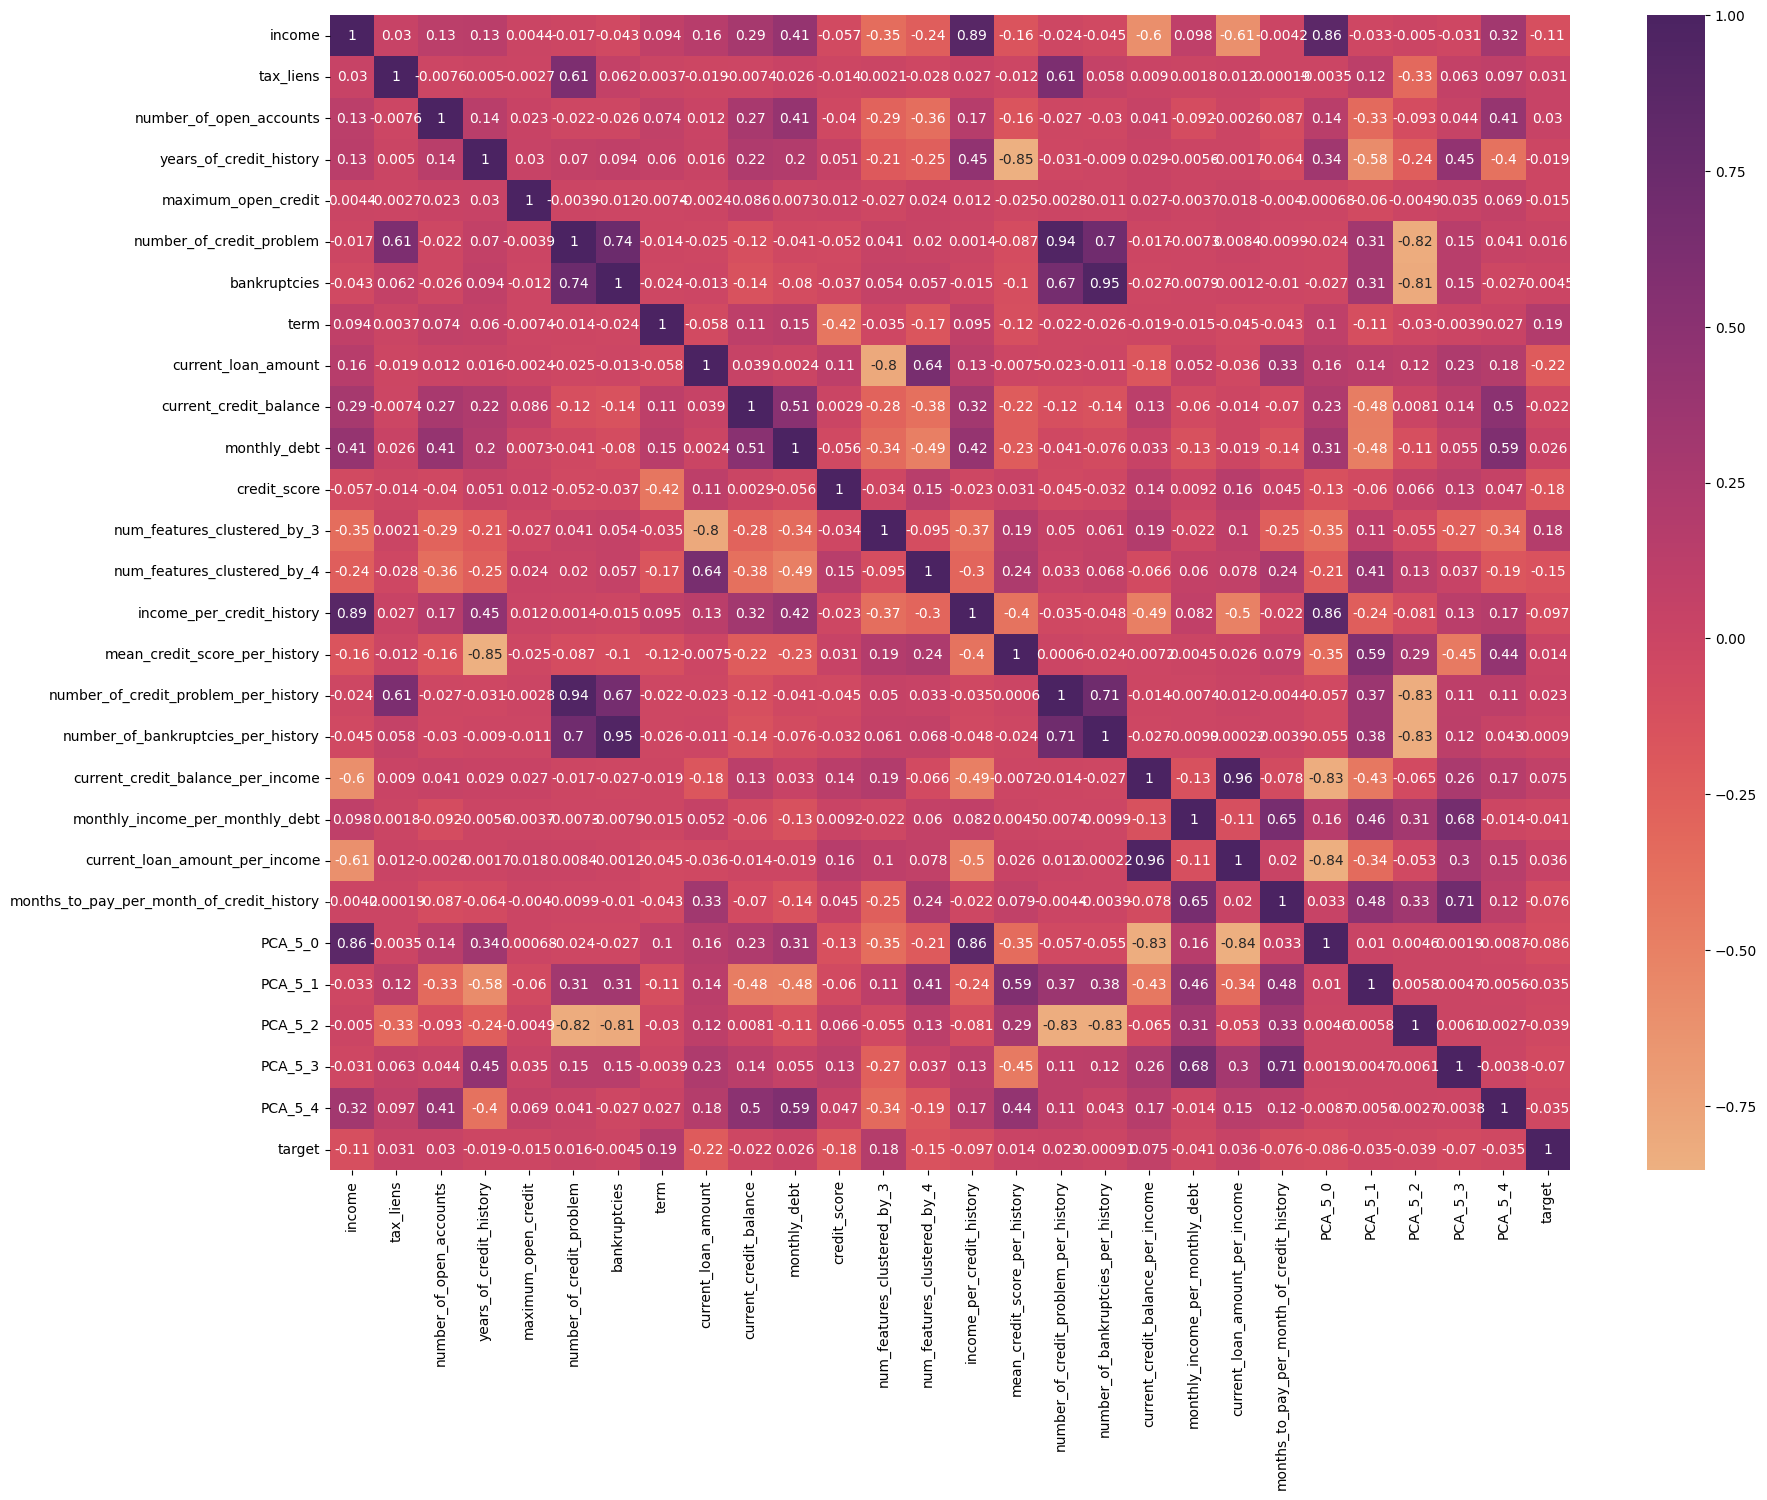

In [13]:

plt.figure(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, cmap='flare')

Попробуем обучить модель на топ n фичах, а затем попробуем решить проблему мультиколлинеарности и обучить ещё раз

In [14]:
selector = SelectFromModel(model, prefit=True)

In [15]:
x_train.shape

(6000, 30)

In [16]:
x_new = selector.transform(x_train)

/home/mogilyoy/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [17]:
x_new_test = selector.transform(x_test)

/home/mogilyoy/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [18]:
x_new.shape

(6000, 9)

In [19]:
params = {'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.02, 'n_estimators': 150}


In [20]:
catboost = CatBoostClassifier(class_weights=[2.1, 5.3], 
                           random_seed=1,
                           **params)

In [21]:
x_new[0, :]

array(['Home Mortgage', 312708.0, 0, 89364.0, 741.0, 2, 1,
       11.806013381201044, 0.0405080504786771], dtype=object)

In [22]:
catboost.fit(x_new, y_train,cat_features=[0, 2, 5, 6])

0:	learn: 0.6909910	total: 54.5ms	remaining: 8.13s
1:	learn: 0.6891437	total: 56.7ms	remaining: 4.2s
2:	learn: 0.6869308	total: 60.4ms	remaining: 2.96s
3:	learn: 0.6851180	total: 63.7ms	remaining: 2.32s
4:	learn: 0.6833040	total: 70.2ms	remaining: 2.03s
5:	learn: 0.6814708	total: 76.2ms	remaining: 1.83s
6:	learn: 0.6797568	total: 90.1ms	remaining: 1.84s
7:	learn: 0.6781762	total: 113ms	remaining: 2.01s
8:	learn: 0.6767768	total: 137ms	remaining: 2.14s
9:	learn: 0.6751791	total: 153ms	remaining: 2.15s
10:	learn: 0.6736661	total: 156ms	remaining: 1.98s
11:	learn: 0.6721601	total: 174ms	remaining: 2s
12:	learn: 0.6707242	total: 177ms	remaining: 1.86s
13:	learn: 0.6691314	total: 183ms	remaining: 1.77s
14:	learn: 0.6677288	total: 187ms	remaining: 1.68s
15:	learn: 0.6663758	total: 189ms	remaining: 1.58s
16:	learn: 0.6651105	total: 207ms	remaining: 1.62s
17:	learn: 0.6639005	total: 210ms	remaining: 1.54s
18:	learn: 0.6627084	total: 228ms	remaining: 1.57s
19:	learn: 0.6615151	total: 245ms	rema

In [23]:
y_pred = catboost.predict(x_new_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1077
           1       0.38      0.66      0.48       423

    accuracy                           0.60      1500
   macro avg       0.59      0.62      0.58      1500
weighted avg       0.69      0.60      0.62      1500



### Борьба с мультиколлинеарностью

Сильная корреляция между признаками: 
- income, income per credit history, PCA_5_0
- years of credit history, mean_credit_score per history
- number of credit problem, bankruptcies, number of credit problem per history, number of bankrupts per history, PCA 5_2

<AxesSubplot:>

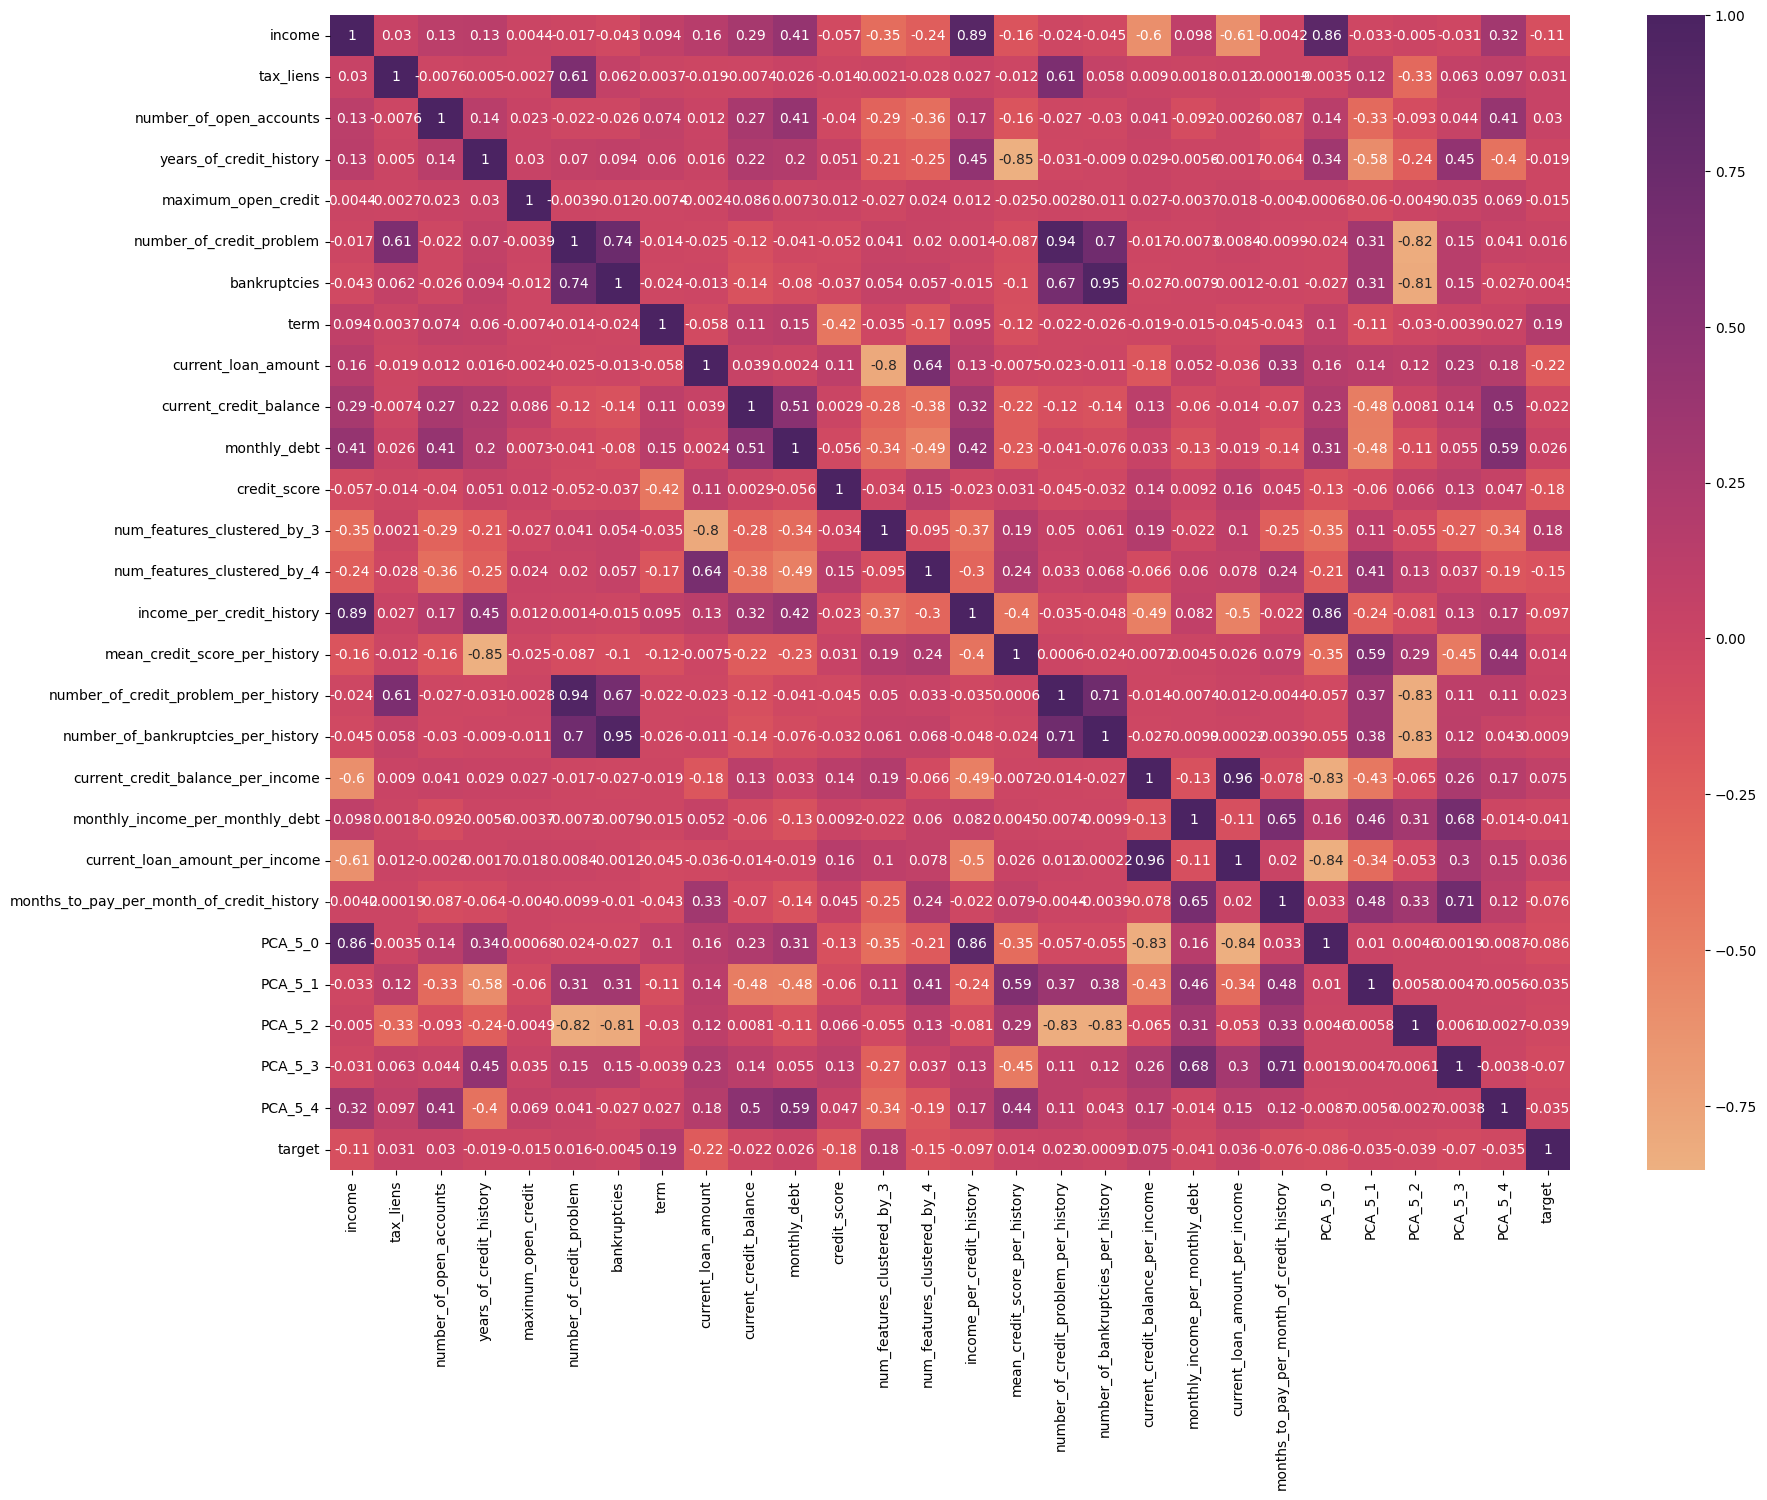

In [24]:
plt.figure(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, cmap='flare')

In [32]:
bad_features = ['number_of_credit_problem_per_history',
                'number_of_bankruptcies_per_history',           
                'mean_credit_score_per_history',                
                'monthly_debt',                                 
                'years_of_credit_history',
                'income_per_credit_history',
                'PCA_5_4']

x_train_top_feats_by_mut_info = x_train.drop(columns=bad_features)

x_test_top_feats_by_mut_info = x_test.drop(columns=bad_features)


In [37]:
model = CatBoostClassifier(class_weights=[2.1, 5.3], 
                           random_seed=1,
                           **params)
categorical_features_indices = np.where(x_train_top_feats_by_mut_info.dtypes != float)[0]
model.fit(x_train_top_feats_by_mut_info, y_train, cat_features=categorical_features_indices)

0:	learn: 0.6887821	total: 83.5ms	remaining: 12.4s
1:	learn: 0.6851309	total: 134ms	remaining: 9.94s
2:	learn: 0.6818140	total: 170ms	remaining: 8.33s
3:	learn: 0.6776972	total: 179ms	remaining: 6.54s
4:	learn: 0.6741305	total: 188ms	remaining: 5.45s
5:	learn: 0.6703306	total: 198ms	remaining: 4.75s
6:	learn: 0.6668398	total: 210ms	remaining: 4.29s
7:	learn: 0.6636479	total: 254ms	remaining: 4.52s
8:	learn: 0.6607715	total: 293ms	remaining: 4.59s
9:	learn: 0.6583979	total: 347ms	remaining: 4.86s
10:	learn: 0.6555173	total: 423ms	remaining: 5.35s
11:	learn: 0.6530256	total: 477ms	remaining: 5.48s
12:	learn: 0.6505080	total: 484ms	remaining: 5.1s
13:	learn: 0.6480106	total: 526ms	remaining: 5.11s
14:	learn: 0.6458233	total: 575ms	remaining: 5.17s
15:	learn: 0.6435197	total: 620ms	remaining: 5.19s
16:	learn: 0.6413810	total: 657ms	remaining: 5.14s
17:	learn: 0.6393064	total: 695ms	remaining: 5.09s
18:	learn: 0.6373929	total: 733ms	remaining: 5.05s
19:	learn: 0.6352143	total: 781ms	remaini

In [38]:
y_pred = model.predict(x_test_top_feats_by_mut_info)

In [40]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70       805
           1       0.65      0.40      0.49       695

    accuracy                           0.62      1500
   macro avg       0.63      0.61      0.60      1500
weighted avg       0.63      0.62      0.60      1500



<AxesSubplot:>

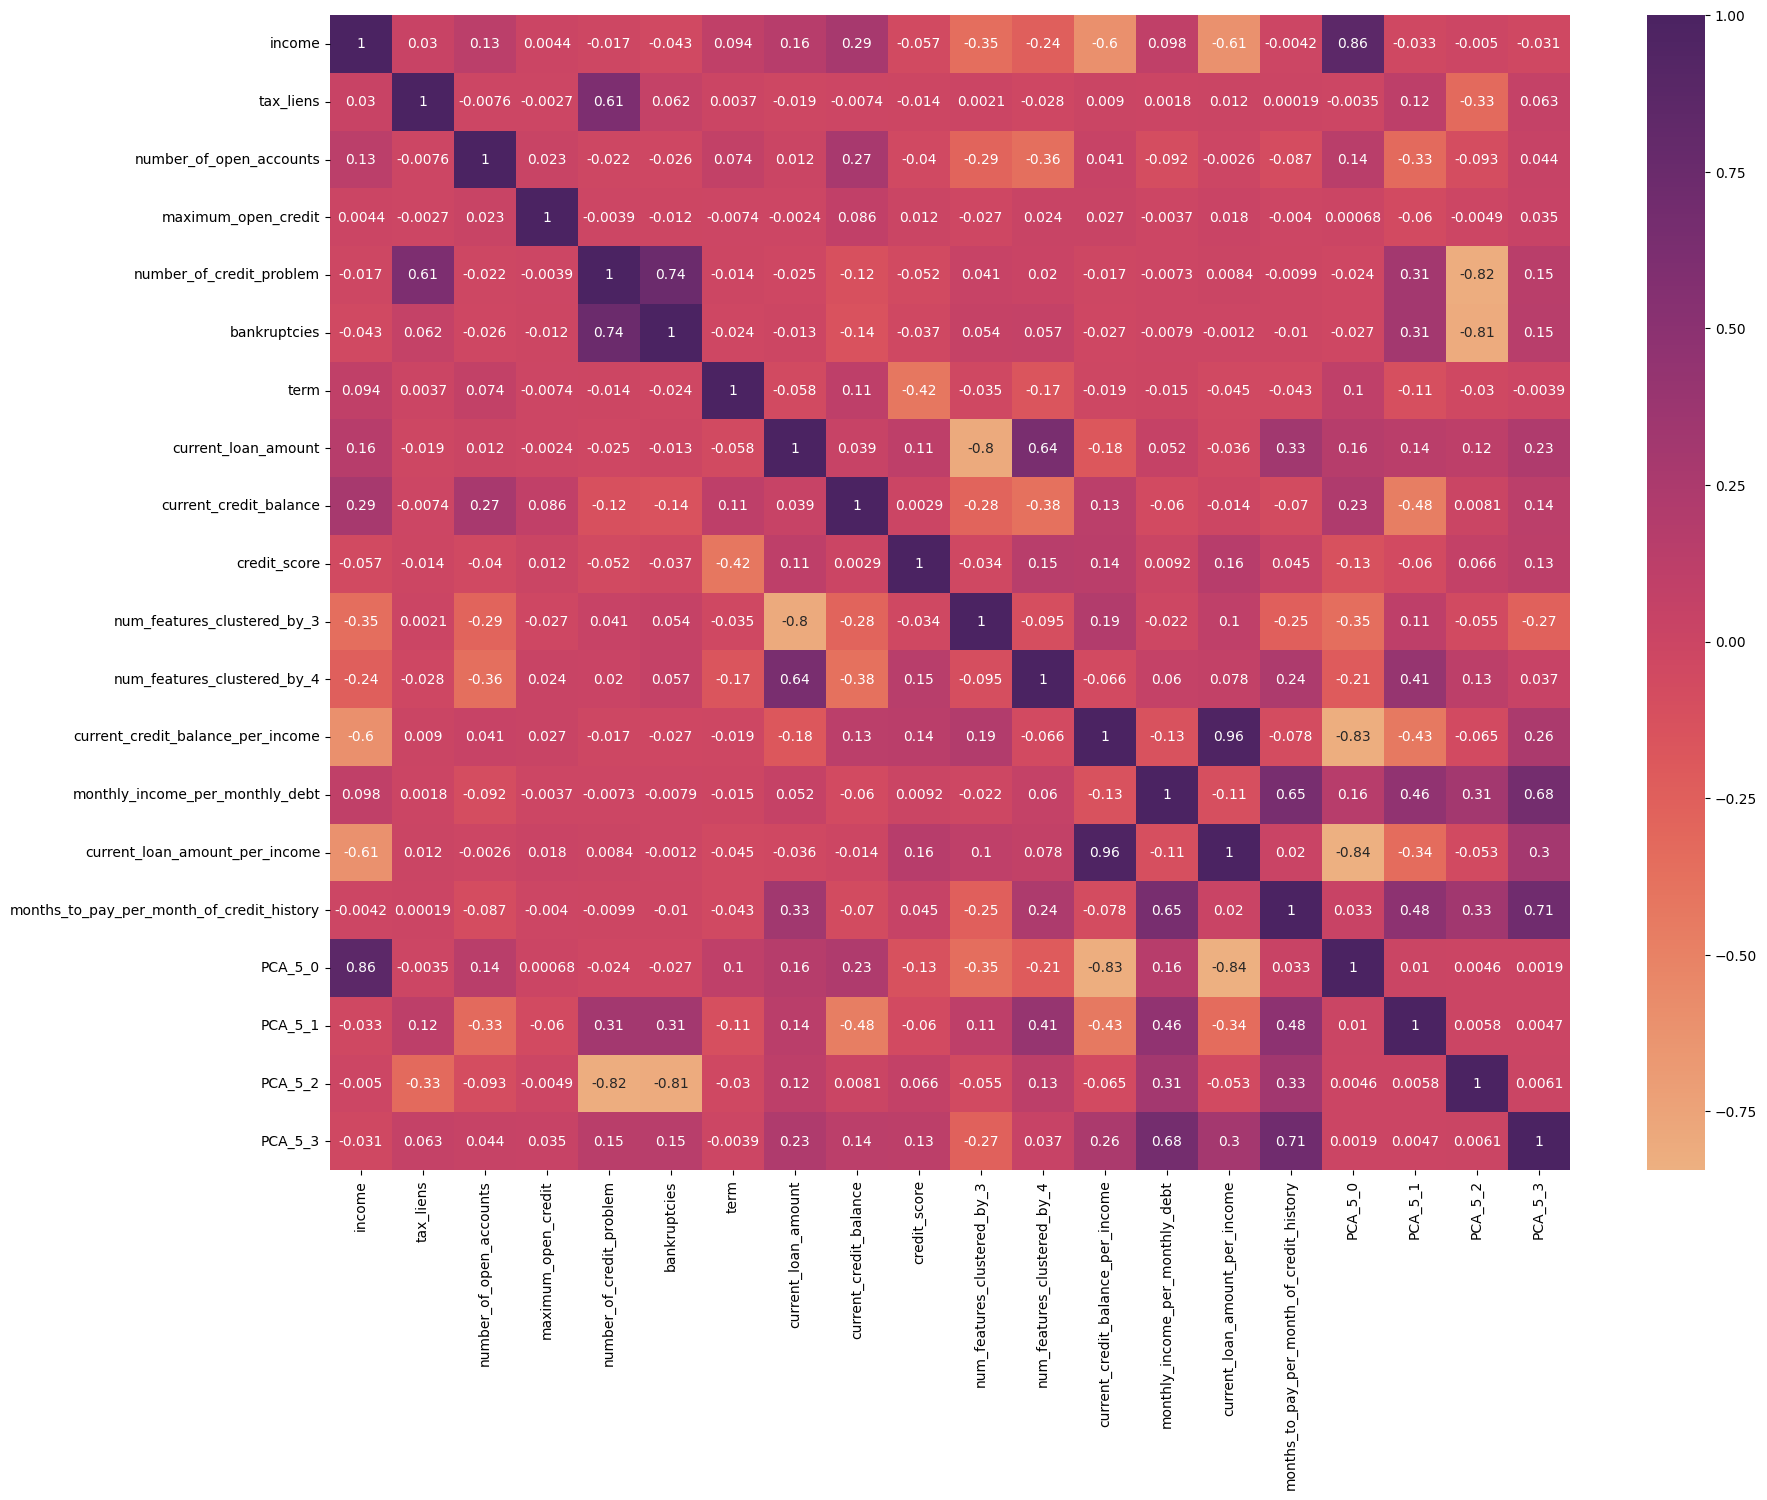

In [41]:
plt.figure(figsize=(20,15))
sns.heatmap(x_train_top_feats_by_mut_info.corr(), annot=True, cmap='flare')

### Permutation importance

In [46]:
importances = permutation_importance(model, x_train, y_train, scoring='f1')['importances_mean']

In [48]:
pd.Series(importances, index=x_train.columns).sort_values()

years_in_current_job                         0.000000
number_of_credit_problem                     0.000000
purpose                                      0.000000
tax_liens                                    0.000301
bankruptcies                                 0.003068
number_of_bankruptcies_per_history           0.004034
number_of_credit_problem_per_history         0.004556
PCA_5_0                                      0.004583
number_of_open_accounts                      0.005300
years_of_credit_history                      0.006178
PCA_5_2                                      0.006974
mean_credit_score_per_history                0.008426
PCA_5_4                                      0.008946
PCA_5_1                                      0.009563
monthly_debt                                 0.010463
income_per_credit_history                    0.011344
months_to_pay_per_month_of_credit_history    0.011373
current_loan_amount_per_income               0.011521
current_credit_balance_per_i

- years_in_current_job                         0.000000
- number_of_credit_problem                     0.000000
- purpose                                      0.000000

Эти фичи вообще не имеют значения

In [63]:
x_train = x_train.drop(columns=['years_in_current_job', 'number_of_credit_problem', 'purpose', 'PCA_5_0', 'PCA_5_2', 'number_of_bankruptcies_per_history'])
x_test = x_test.drop(columns=['years_in_current_job', 'number_of_credit_problem', 'purpose', 'PCA_5_0', 'PCA_5_2', 'number_of_bankruptcies_per_history'])

In [64]:
model = CatBoostClassifier(class_weights=[2.1, 5.3], 
                           random_seed=1,
                           silent=True,
                           **params)
categorical_features_indices = np.where(x_train.dtypes != float)[0]
model.fit(x_train, y_train, cat_features=categorical_features_indices)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1077
           1       0.40      0.63      0.49       423

    accuracy                           0.63      1500
   macro avg       0.61      0.63      0.60      1500
weighted avg       0.70      0.63      0.65      1500



<AxesSubplot:>

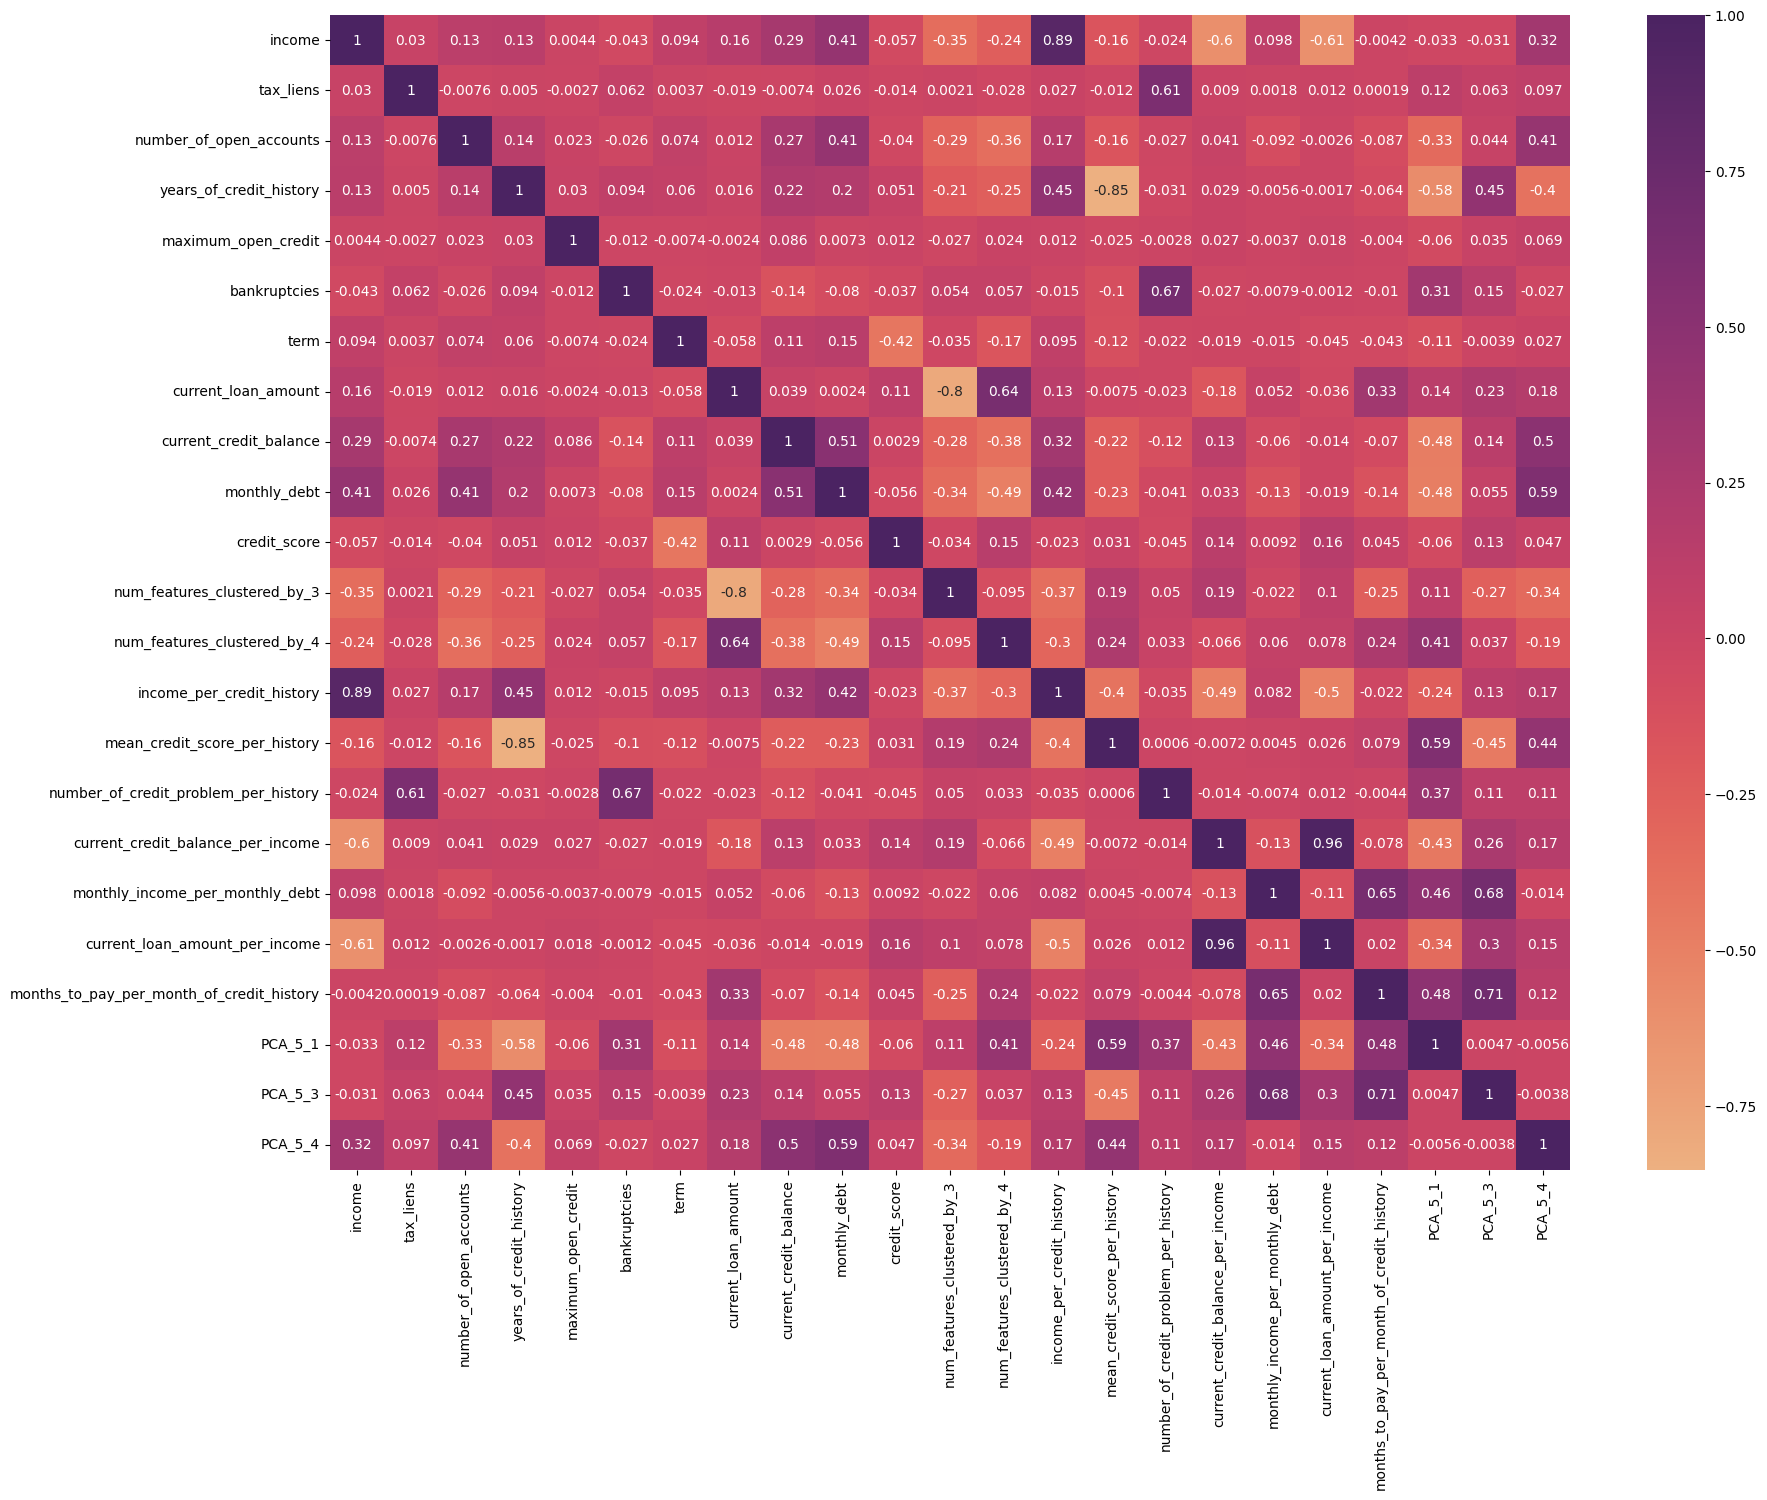

In [65]:
plt.figure(figsize=(20,15))
sns.heatmap(x_train.corr(), annot=True, cmap='flare')

Исключение коллинеарных фичей понижает результат работы модели. Попробуем заменить коллинеарные через PCA

In [67]:
def get_pca_feature_from_collinear_feats(dataframe, feature_names, n_components=1):
    data_to_pca = StandardScaler().fit_transform(dataframe[feature_names].copy())
    pca = PCA(n_components=n_components)
    result_feature = pca.fit_transform(data_to_pca)
    return result_feature

<AxesSubplot:>

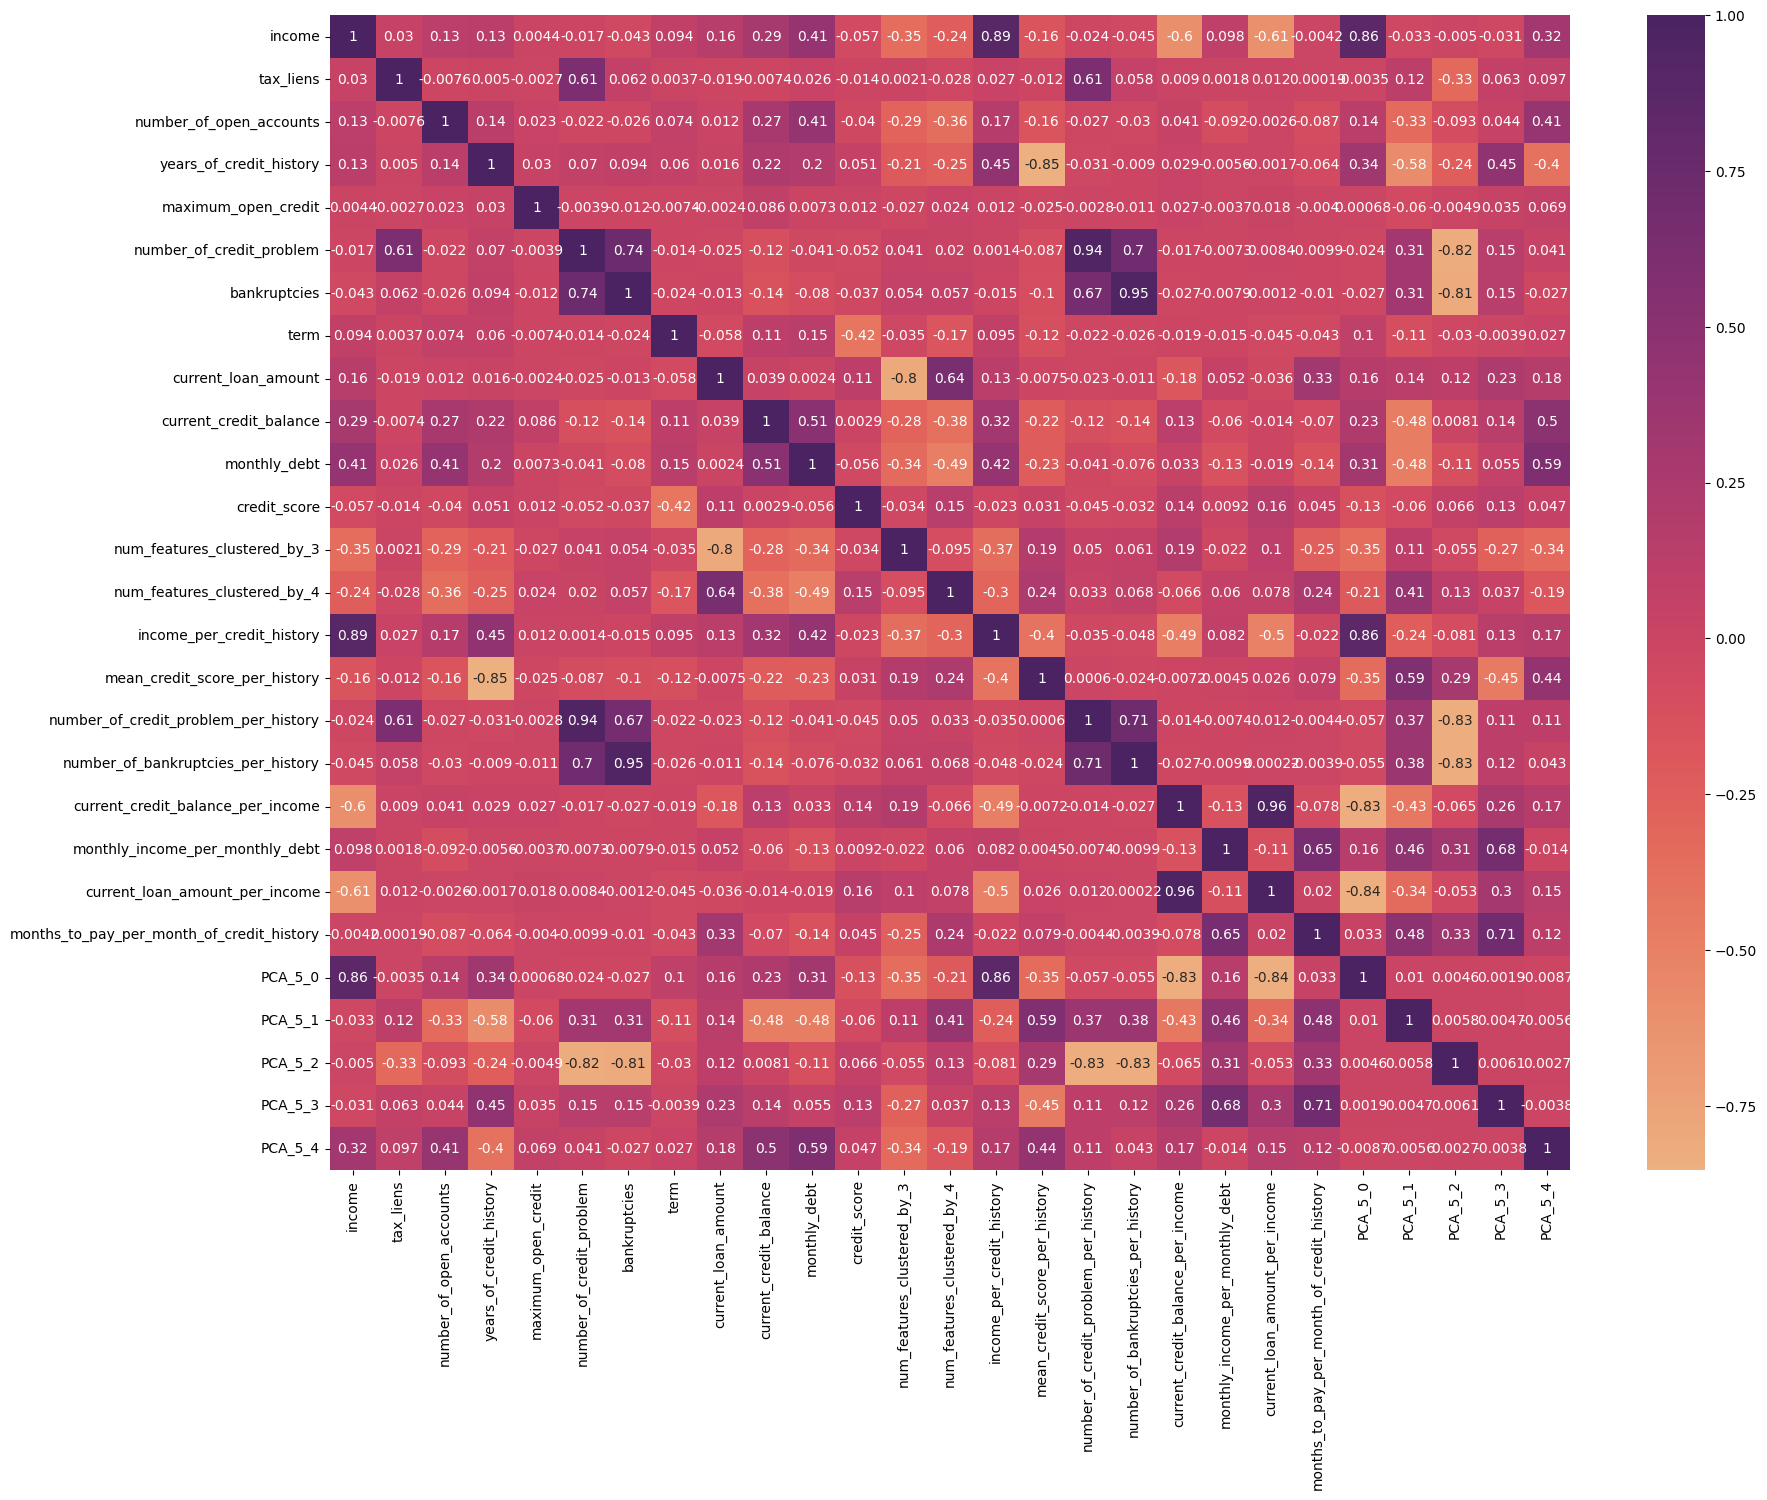

In [69]:
plt.figure(figsize=(20,15))
sns.heatmap(x_train.corr(), annot=True, cmap='flare')

In [70]:
x_train.corr()

,income,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problem,bankruptcies,term,current_loan_amount,current_credit_balance,...,number_of_bankruptcies_per_history,current_credit_balance_per_income,monthly_income_per_monthly_debt,current_loan_amount_per_income,months_to_pay_per_month_of_credit_history,PCA_5_0,PCA_5_1,PCA_5_2,PCA_5_3,PCA_5_4
income,1.000000,0.030285,0.131030,0.134559,0.004386,-0.016655,-0.042937,0.093536,0.157580,0.286028,...,-0.045264,-0.604182,0.098318,-0.609621,-0.004181,0.860337,-0.033232,-0.004979,-0.030878,0.315161
tax_liens,0.030285,1.000000,-0.007622,0.005028,-0.002682,0.608773,0.062159,0.003697,-0.018746,-0.007372,...,0.058343,0.009047,0.001751,0.011861,0.000187,-0.003496,0.120426,-0.331365,0.062820,0.096652
number_of_open_accounts,0.131030,-0.007622,1.000000,0.141643,0.022958,-0.022261,-0.025993,0.074402,0.011713,0.272636,...,-0.029627,0.041028,-0.091971,-0.002632,-0.086903,0.143706,-0.332190,-0.092653,0.044038,0.409581
years_of_credit_history,0.134559,0.005028,0.141643,1.000000,0.030301,0.070489,0.094072,0.059900,0.015723,0.221753,...,-0.009039,0.028705,-0.005601,-0.001747,-0.064384,0.338252,-0.582479,-0.239153,0.448835,-0.396642
maximum_open_credit,0.004386,-0.002682,0.022958,0.030301,1.000000,-0.003881,-0.011516,-0.007426,-0.002432,0.086058,...,-0.011152,0.026711,-0.003725,0.018327,-0.004046,0.000682,-0.059635,-0.004866,0.035330,0.069145
number_of_credit_problem,-0.016655,0.608773,-0.022261,0.070489,-0.003881,1.000000,0.742313,-0.014070,-0.024736,-0.119999,...,0.703401,-0.017064,-0.007289,0.008432,-0.009946,-0.023992,0.312847,-0.820627,0.149805,0.041275
bankruptcies,-0.042937,0.062159,-0.025993,0.094072,-0.011516,0.742313,1.000000,-0.023594,-0.013167,-0.140686,...,0.947613,-0.027012,-0.007879,-0.001154,-0.010208,-0.026733,0.312572,-0.807113,0.150918,-0.027103
term,0.093536,0.003697,0.074402,0.059900,-0.007426,-0.014070,-0.023594,1.000000,-0.058395,0.109751,...,-0.025891,-0.018757,-0.015193,-0.045332,-0.042726,0.102222,-0.105407,-0.030388,-0.003862,0.026798
current_loan_amount,0.157580,-0.018746,0.011713,0.015723,-0.002432,-0.024736,-0.013167,-0.058395,1.000000,0.039038,...,-0.011027,-0.182566,0.051601,-0.035660,0.325512,0.164627,0.136373,0.116313,0.229140,0.180545
current_credit_balance,0.286028,-0.007372,0.272636,0.221753,0.086058,-0.119999,-0.140686,0.109751,0.039038,1.000000,...,-0.140829,0.129668,-0.059713,-0.014423,-0.070423,0.225162,-0.476056,0.008109,0.135398,0.498187


In [82]:
colummns_after_pca = []

x_train.corr()[(x_train.corr() > 0.7)|(x_test.corr() < -0.7)]


,income,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problem,bankruptcies,term,current_loan_amount,current_credit_balance,...,number_of_bankruptcies_per_history,current_credit_balance_per_income,monthly_income_per_monthly_debt,current_loan_amount_per_income,months_to_pay_per_month_of_credit_history,PCA_5_0,PCA_5_1,PCA_5_2,PCA_5_3,PCA_5_4
income,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.860337,NaN,NaN,NaN,NaN
tax_liens,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_open_accounts,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
years_of_credit_history,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maximum_open_credit,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_credit_problem,NaN,NaN,NaN,NaN,NaN,1.000000,0.742313,NaN,NaN,NaN,...,0.703401,NaN,NaN,NaN,NaN,NaN,NaN,-0.820627,NaN,NaN
bankruptcies,NaN,NaN,NaN,NaN,NaN,0.742313,1.000000,NaN,NaN,NaN,...,0.947613,NaN,NaN,NaN,NaN,NaN,NaN,-0.807113,NaN,NaN
term,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
current_loan_amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
current_credit_balance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
income_coef_1 = get_pca_feature_from_collinear_feats(x_train, ['income', 'income_per_credit_history'])
income_coef_2 = get_pca_feature_from_collinear_feats(x_train, ['income', 'PCA_5_0'])

years_of_credit_history_coef_1 = get_pca_feature_from_collinear_feats(x_train, ['years_of_credit_history', 'mean_credit_score_per_history'])

number_of_credit_problem_coef_1 = get_pca_feature_from_collinear_feats(x_train, ['number_of_credit_problem', 'bankruptcies'])
number_of_credit_problem_coef_2 = get_pca_feature_from_collinear_feats(x_train, ['number_of_credit_problem', 'number_of_credit_problem_per_history'])
number_of_credit_problem_coef_3 = get_pca_feature_from_collinear_feats(x_train, ['number_of_credit_problem', 'number_of_bankruptcies_per_history'])
number_of_credit_problem_coef_4 = get_pca_feature_from_collinear_feats(x_train, ['number_of_credit_problem', 'PCA_5_2'])


bankruptcies_coef_1 = get_pca_feature_from_collinear_feats(x_train, ['bankruptcies', 'number_of_bankruptcies_per_history'])
bankruptcies_coef_2 = get_pca_feature_from_collinear_feats(x_train, ['bankruptcies', 'PCA_5_2'])

In [87]:
income_coef_1_test = get_pca_feature_from_collinear_feats(x_test, ['income', 'income_per_credit_history'])
income_coef_2_test = get_pca_feature_from_collinear_feats(x_test, ['income', 'PCA_5_0'])

years_of_credit_history_coef_1_test = get_pca_feature_from_collinear_feats(x_test, ['years_of_credit_history', 'mean_credit_score_per_history'])

number_of_credit_problem_coef_1_test = get_pca_feature_from_collinear_feats(x_test, ['number_of_credit_problem', 'bankruptcies'])
number_of_credit_problem_coef_2_test = get_pca_feature_from_collinear_feats(x_test, ['number_of_credit_problem', 'number_of_credit_problem_per_history'])
number_of_credit_problem_coef_3_test = get_pca_feature_from_collinear_feats(x_test, ['number_of_credit_problem', 'number_of_bankruptcies_per_history'])
number_of_credit_problem_coef_4_test = get_pca_feature_from_collinear_feats(x_test, ['number_of_credit_problem', 'PCA_5_2'])


bankruptcies_coef_1_test = get_pca_feature_from_collinear_feats(x_test, ['bankruptcies', 'number_of_bankruptcies_per_history'])
bankruptcies_coef_2_test = get_pca_feature_from_collinear_feats(x_test, ['bankruptcies', 'PCA_5_2'])

In [85]:
x_train_pca_modified_features = x_train.drop(columns=['income', 
                                                      'income_per_credit_history',
                                                      'PCA_5_0',
                                                      'years_of_credit_history',
                                                      'mean_credit_score_per_history',
                                                      'number_of_credit_problem',
                                                      'bankruptcies',
                                                      'number_of_credit_problem_per_history',
                                                      'number_of_bankruptcies_per_history',
                                                      'PCA_5_2'
                                                      ])


x_test_pca_modified_features = x_test.drop(columns=['income', 
                                                      'income_per_credit_history',
                                                      'PCA_5_0',
                                                      'years_of_credit_history',
                                                      'mean_credit_score_per_history',
                                                      'number_of_credit_problem',
                                                      'bankruptcies',
                                                      'number_of_credit_problem_per_history',
                                                      'number_of_bankruptcies_per_history',
                                                      'PCA_5_2'
                                                      ])

In [86]:
x_train_pca_modified_features['income_coef_1'] = income_coef_1
x_train_pca_modified_features['income_coef_2'] = income_coef_2
x_train_pca_modified_features['years_of_credit_history_coef_1'] = years_of_credit_history_coef_1
x_train_pca_modified_features['number_of_credit_problem_coef_1'] = number_of_credit_problem_coef_1
x_train_pca_modified_features['number_of_credit_problem_coef_2'] = number_of_credit_problem_coef_2
x_train_pca_modified_features['number_of_credit_problem_coef_3'] = number_of_credit_problem_coef_3
x_train_pca_modified_features['number_of_credit_problem_coef_4'] = number_of_credit_problem_coef_4
x_train_pca_modified_features['bankruptcies_coef_1'] = bankruptcies_coef_1 
x_train_pca_modified_features['bankruptcies_coef_2'] = bankruptcies_coef_2


In [88]:
x_test_pca_modified_features['income_coef_1'] = income_coef_1_test
x_test_pca_modified_features['income_coef_2'] = income_coef_2_test
x_test_pca_modified_features['years_of_credit_history_coef_1'] = years_of_credit_history_coef_1_test
x_test_pca_modified_features['number_of_credit_problem_coef_1'] = number_of_credit_problem_coef_1_test
x_test_pca_modified_features['number_of_credit_problem_coef_2'] = number_of_credit_problem_coef_2_test
x_test_pca_modified_features['number_of_credit_problem_coef_3'] = number_of_credit_problem_coef_3_test
x_test_pca_modified_features['number_of_credit_problem_coef_4'] = number_of_credit_problem_coef_4_test
x_test_pca_modified_features['bankruptcies_coef_1'] = bankruptcies_coef_1_test
x_test_pca_modified_features['bankruptcies_coef_2'] = bankruptcies_coef_2_test

In [89]:
model = CatBoostClassifier(class_weights=[2.1, 5.3], 
                           random_seed=1,
                           silent=True,
                           **params)
categorical_features_indices = np.where(x_train_pca_modified_features.dtypes != float)[0]
model.fit(x_train_pca_modified_features, y_train, cat_features=categorical_features_indices)
y_pred = model.predict(x_test_pca_modified_features)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1077
           1       0.40      0.63      0.49       423

    accuracy                           0.63      1500
   macro avg       0.60      0.63      0.60      1500
weighted avg       0.69      0.63      0.64      1500



Все сделанные преобразования только уменьшают метрику